In [101]:
import torch
from torch import nn, tensor, optim
from torch.utils.data import Dataset, DataLoader

import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import precision_recall_curve, roc_curve

from Xas2Quality_dataloader import *
from Xas2Quality_model import *
from Xas2Quality_trainer import *

%reload_ext autoreload
%autoreload 1
%aimport Xas2Quality_dataloader, Xas2Quality_model, Xas2Quality_trainer, seaborn

from torch.utils.tensorboard import SummaryWriter

## Reading data and derivative

In [2]:
data = np.arange(299*1000).reshape(1000,1,299)
data = tensor(data,dtype=torch.float)
conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=2, stride=1,padding_mode='reflect',padding=1)

In [15]:
data.shape

torch.Size([1000, 1, 299])

In [23]:
cnn = Xas2QualityCNN(output_size=1)
# cnn.to(torch.device('cuda'))

In [24]:
cnn(data).shape

torch.Size([1000, 1])

In [96]:
data = Xas2QualityDataset.from_file(spec_file="e7600-8000_grid400_spec_norm.pkl",
                                    quality_file="e7600-8000_grid400_prediction.pkl",
                                    energy_cut=(7600,7900))

Original | Label_1: 8171; Label_0: 4217
Balanced | Label_1: 4217.0; Label_0: 4217.0
Feature size: 299


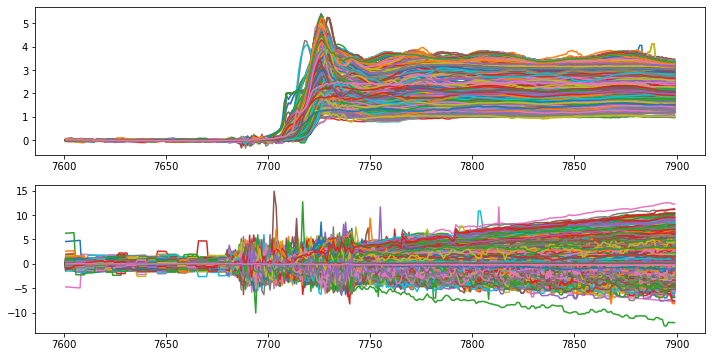

In [26]:
fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(data.feature, data.data[(data.label==1).reshape(-1)].T)
axs[1].plot(data.feature, data.data[(data.label==0).reshape(-1)].T)
plt.show()

#### Some useful links
https://discuss.pytorch.org/t/difference-between-nn-linear-nn-crossentropyloss-and-nn-logsoftmax-nn-nllloss/21634

In [97]:
portion = [0.7, 0.2, 0.1]
N_samples = len(data)
N_train = int(np.ceil(N_samples * portion[0]))
N_val = int(np.ceil(N_samples * portion[1]))
N_test = N_samples - N_train - N_val
assert N_samples == N_train + N_val + N_test

dtype = torch.float
device = torch.device("cuda")

d = data.data
l = data.label
x_train = tensor(d[:N_train],dtype=dtype,device=device)[:,np.newaxis,:]
y_train = tensor(l[:N_train],dtype=dtype,device=device)

x_val = tensor(d[N_train:N_train+N_val],dtype=dtype,device=device)[:,np.newaxis,:]
y_val = tensor(l[N_train:N_train+N_val],dtype=dtype,device=device)

x_test = tensor(d[-N_test:],dtype=dtype, device=device)[:,np.newaxis,:]
y_test = tensor(l[-N_test:],dtype=dtype, device=device)



print("Data shape for: Training | Validation | Test")
print("data:", x_train.size(),  x_val.size(), x_test.size())
print("label:", y_train.size(),  y_val.size(), y_test.size())

assert y_train.size()[0] == N_train
assert y_val.size()[0] == N_val
assert y_test.size()[0] == N_test

dd = {'train': (x_train, y_train),
         'val': (x_val, y_val),
         'test': (x_test, y_test)}

Data shape for: Training | Validation | Test
data: torch.Size([5904, 1, 299]) torch.Size([1687, 1, 299]) torch.Size([843, 1, 299])
label: torch.Size([5904, 1]) torch.Size([1687, 1]) torch.Size([843, 1])


In [122]:
def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()


model = Xas2QualityCNN(output_size=1, dropout_rate=0.4)
model.apply(weight_reset)

trainer = Trainer(model, dd, device=torch.device("cuda"), verbose=True, learning_rate=1e-4,
                  max_epochs=1000, batch_size=200,board=False)

train_loss, val_loss = trainer.train()

Tensorboard is off
Epoch 100/1000 | loss: 0.231/0.215
Epoch 200/1000 | loss: 0.195/0.182
Epoch 300/1000 | loss: 0.187/0.175
Epoch 400/1000 | loss: 0.175/0.163
Epoch 500/1000 | loss: 0.152/0.142
Epoch 600/1000 | loss: 0.160/0.152
Epoch 700/1000 | loss: 0.151/0.143
Epoch 800/1000 | loss: 0.143/0.135
Epoch 900/1000 | loss: 0.136/0.129
Epoch 1000/1000 | loss: 0.129/0.124
Total time: 5.5 min.


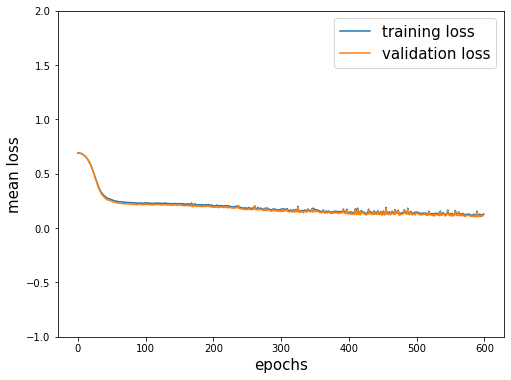

In [104]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
epochs = np.arange(trainer.max_epochs)
ax.plot(epochs,train_loss,label='training loss')
ax.plot(epochs,val_loss,label='validation loss')
ax.set_xlabel('epochs',fontsize=15)
ax.set_ylabel('mean loss',fontsize=15)
ax.legend(fontsize=15)
ax.set_ylim([-1,2])
plt.show()

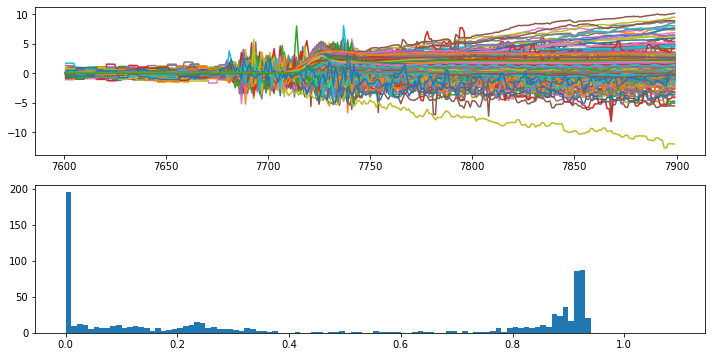

In [105]:
y_score = model(x_test).detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()

fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(data.feature, x_test[:,0,:].detach().cpu().numpy().T)
axs[1].hist(y_score,bins=np.arange(0,1.1,0.01))
plt.show()

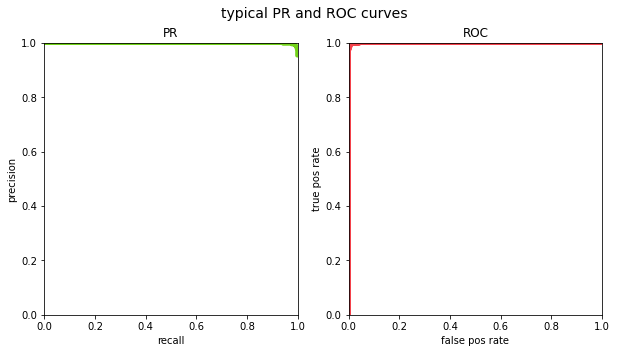

In [106]:
GREEN = '#72d218'
RED = '#f4424b'
BLUE = '#72bdff'


def label_plot(ax, is_pr=True):
    x, y = (('recall', 'precision')
            if is_pr else
            ('false pos rate', 'true pos rate'))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    
def plot_pr_and_roc(y_true, y_pred, title):
    p, r, _ = precision_recall_curve(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].plot(r, p, lw=4, color=GREEN)
    axs[0].set_title('PR')
    label_plot(axs[0], is_pr=True)

    axs[1].plot(fpr, tpr, lw=4, color=RED)
    axs[1].set_title('ROC')
    label_plot(axs[1], is_pr=False)

    fig.suptitle(title, fontsize=14)
    
plot_pr_and_roc(y_true, y_score, title='typical PR and ROC curves')

In [50]:
# N_sample = len(data)
# index = np.arange(N_sample)
# test_mask = ~(masks['good']|masks['bad'])

# # label score (1 or 0) or predicted scores for all the data
# labels = np.zeros(N_sample,dtype=float)
# labels[masks['good']] = int(1)
# labels[masks['bad']] = int(0)
# labels[index[test_mask]] = y_test_pred.reshape(-1)

# # train/test label for all the date
# sets = ['train'] * N_sample
# for i in index[test_mask]: sets[i] = 'test'

# result = {'set': sets,
#           'label': labels}

# with open("e{}-{}_grid400_prediction.pkl".format(int(norm_left),int(norm_right)),'wb') as f:
#     pickle.dump(result,f)

NameError: name 'masks' is not defined

424/843


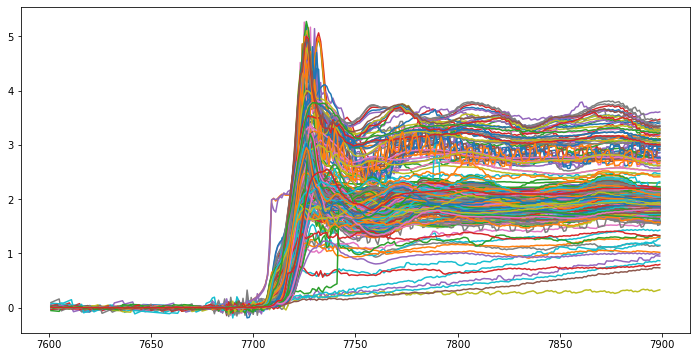

In [114]:
plot_select = (y_score > 0.3).reshape(-1)
fig, ax = plt.subplots(figsize=(12,6))
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))
for i,d in enumerate(x_test[:,0,:].detach().cpu().numpy()[plot_select]):
    ax.plot(data.feature, d)

419/843


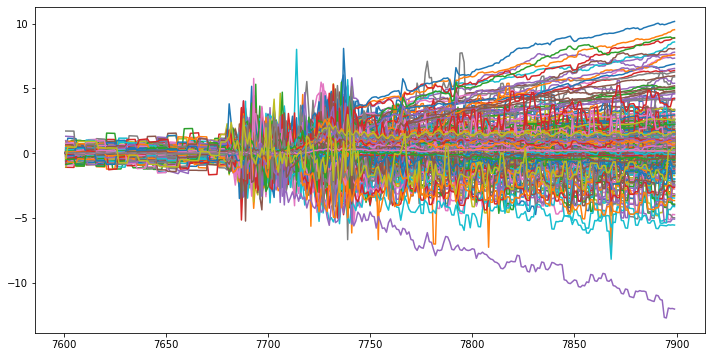

In [113]:
plot_select = (y_score < 0.3).reshape(-1)
fig, ax = plt.subplots(figsize=(12,6))
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))
for i,d in enumerate(x_test[:,0,:].detach().cpu().numpy()[plot_select]):
    ax.plot(data.feature, d)

31/843


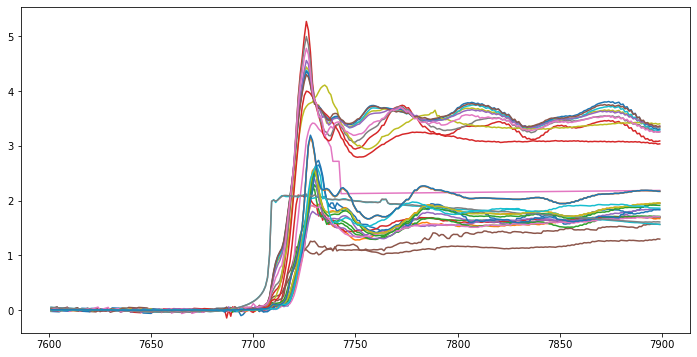

In [115]:
plot_select = ((y_score > 0.6)&(y_score < 0.8)).reshape(-1)
fig, ax = plt.subplots(figsize=(12,6))
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))
for i,d in enumerate(x_test[:,0,:].detach().cpu().numpy()[plot_select]):
    ax.plot(data.feature, d)

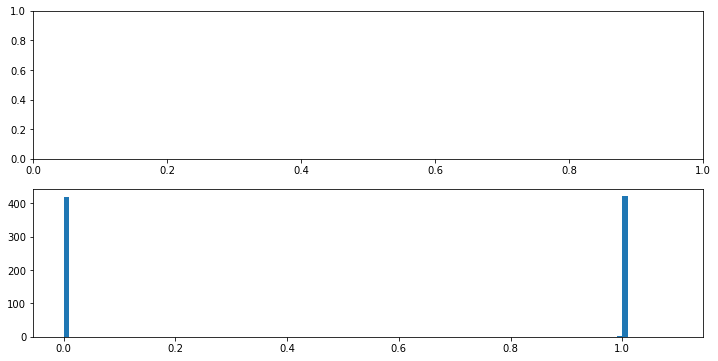

In [88]:
y_score = model(x_test).detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()

fig, axs = plt.subplots(2,1, figsize=(12,6))
# axs[0].plot(data.feature, x_test[:,0,:].detach().cpu().numpy().T)
axs[1].hist(y_score,bins=np.arange(0,1.1,0.01))
plt.show()

In [116]:
norm_left = 7600
norm_right = 8000

with open("e{}-{}_grid400_spec_norm.pkl".format(int(norm_left),int(norm_right)),'rb') as f:
    spec_norm = pickle.load(f)
feature_grid = spec_norm['feature_grid']
energy_select = (feature_grid>7600) & (feature_grid<7900)

red_norm = spec_norm['spec'][:,energy_select]
feature_grid = spec_norm['feature_grid'][energy_select]
# read predicted labels from Neural networks
with open("e{}-{}_grid400_prediction.pkl".format(int(norm_left),int(norm_right)),'rb') as f:
    result = pickle.load(f)
    
labels = result['label']
sets = np.array(result['set'])

In [117]:
data_to_pred = tensor(red_norm[sets=='test'][:,np.newaxis,:],
                      dtype=torch.float, device=torch.device('cuda'),requires_grad=True)

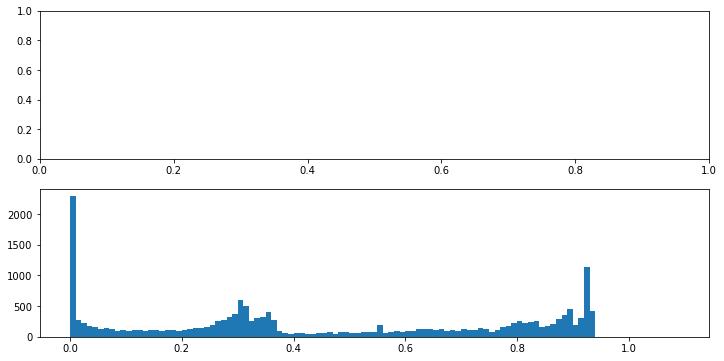

In [118]:
score = model(data_to_pred).detach().cpu().numpy()
fig, axs = plt.subplots(2,1, figsize=(12,6))
# axs[0].plot(data.feature, x_test[:,0,:].detach().cpu().numpy().T)
axs[1].hist(score,bins=np.arange(0,1.1,0.01))
plt.show()

4780/18386


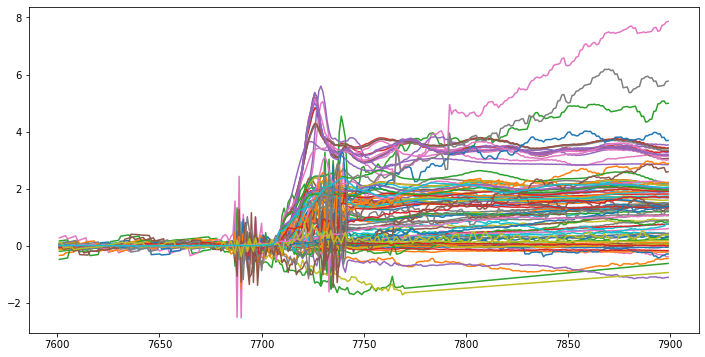

In [121]:
plot_select = ((score < 0.2)&(score<0.4)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.shape[0],size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[:,0,:][random_select].detach().cpu().numpy()):
    ax.plot(data.feature, d)

8291/18386


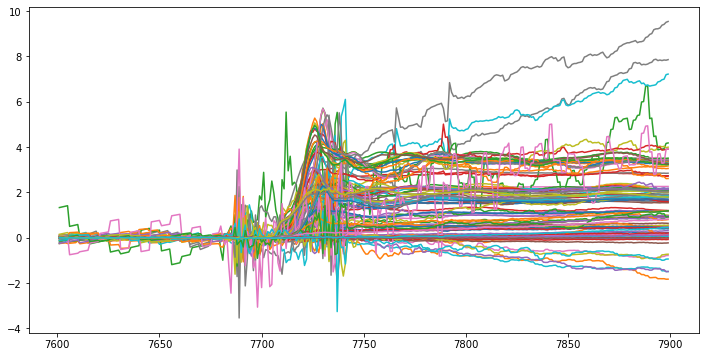

In [56]:
plot_select = (score > (1-0.5)).reshape(-1)
print("{}/{}".format(plot_select.sum(),plot_select.shape[0]))

random_select = list(np.random.randint(plot_select.shape[0],size=100))
fig, ax = plt.subplots(figsize=(12,6))
for i,d in enumerate(data_to_pred[:,0,:][random_select].detach().cpu().numpy()):
    ax.plot(data.feature, d)

In [ ]:
model = Xas2QualityCNN(output_size=1, dropout_rate=0.4)